<a href="https://colab.research.google.com/github/cisirtraining/summerschool/blob/master/Day2_LSTM_timeseries_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Mount Google Drive for Data Access**

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install scikit-plot

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize


  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=400627cfc37ea673f2a7a9685d58d80407229ac66470c4f1962a2498093e8026
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [3]:
import psutil
import humanize
import os
import GPUtil as GPU


GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

print('****** GPU Information: ******\n')
printm()

#!kill -9 -1 #kill virtual machine and assign new one

****** GPU Information: ******

Gen RAM Free: 12.8 GB  | Proc size: 111.5 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


#**Detail Info on LSTM**
Excellent blog post:
[Reference](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

If you interested in maths behind LSTM, read the following (I warn you, think twice ^^):
[Paper](https://arxiv.org/abs/1909.09586)

##Recurrent Neural Networks

The idea behind RNNs is to make use of sequential information. In a traditional neural network we assume that all inputs (and outputs) are independent of each other. But for many tasks that’s a very bad idea. If you want to predict the next word in a sentence you better know which words came before it. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations and you already know that they have a “memory” which captures information about what has been calculated so far.

![](https://drive.google.com/uc?id=1EW9HBneLrcleW1IBR0GE2VJrZhPG-pkc)
## Issues of RNN:
*   Vanishing gradient problem
*   Exploding gradient problem

## Long-Short Term Memory(LSTM)
The LSTM has three gates that update and control the cell states, these are the forget gate, input gate and output gate. The gates use hyperbolic tangent and sigmoid activation functions. 

![alt text](https://drive.google.com/uc?id=1coyG3t6Mbe04WPn8xPdL-64zmdz1oidj)
[Source](https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/)


The forget gate controls what information in the cell state to forget, given new information than entered the network.

![alt text](https://drive.google.com/uc?id=1q-iNGMv_OGIuwpQ7xxtec_wwxo0rhB7j)
[Source](https://medium.com/datadriveninvestor/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577)

The input gate controls what new information will be encoded into the cell state, given the new input information.
![alt text](https://drive.google.com/uc?id=17432J3U9VTGqsf76LzuH96XwkGjk-aji)
[Source](https://medium.com/datadriveninvestor/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577)

The output gate controls what information encoded in the cell state is sent to the network as input in the following time step, this is done via the output vector Ht.
![alt text](https://drive.google.com/uc?id=1u7zWxzP__o0lEhuNzvUjufj886KEcAqf)
[Source](https://medium.com/datadriveninvestor/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577)

##**Dataset Description**

>### Bonn Epileptic Dataset
Source: http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3
 <figure>
<center>
<img src='https://drive.google.com/uc?id=1eIc9eI6ByIt7onVJ2pv6-EQ44qbbTYnT' />
</center>
</figure>



* Bonn dataset is categorized into 5 subsets (A - E), each subset contains 100 single-channel EEG signals of 23.6 seconds obtained from 5 patients - recorded at 173.61 Hz with 12-bit resolution.   
*   Example of raw signal is depicted in the figure with only set E contains epileptic seizure activity.
&nbsp;&nbsp;

<figure>
<center>
<img src='https://drive.google.com/uc?id=1xhvMyPXe_-pkEOwl3Yf0qZkUyiFu6yp4' />
</center>
</figure>



##**Download EEG Dataset**

*  dataset from Bonn University Epilepsy Dataset
*   100 files for each set and 4097 samples per file




In [4]:
!wget http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/Z.zip  # Set A
!wget http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/O.zip  # Set B
!wget http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/N.zip  # Set C
!wget http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/F.zip  # Set D
!wget http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/S.zip  # Set E
  
!unzip Z.zip -d 'Set A'
!unzip O.zip -d 'Set B'
!unzip N.zip -d 'Set C'
!unzip F.zip -d 'Set D'
!unzip S.zip -d 'Set E'
  

--2020-09-16 14:01:32--  http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/Z.zip
Resolving epileptologie-bonn.de (epileptologie-bonn.de)... 83.169.36.208
Connecting to epileptologie-bonn.de (epileptologie-bonn.de)|83.169.36.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 578047 (564K) [application/zip]
Saving to: ‘Z.zip’

Z.zip               100%[===================>] 564.50K   208KB/s    in 2.7s    

2020-09-16 14:01:36 (208 KB/s) - ‘Z.zip’ saved [578047/578047]

--2020-09-16 14:01:36--  http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/O.zip
Resolving epileptologie-bonn.de (epileptologie-bonn.de)... 83.169.36.208
Connecting to epileptologie-bonn.de (epileptologie-bonn.de)|83.169.36.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625970 (611K) [application/zip]
Saving to: ‘O.zip’

O.zip               100%[===================>] 611.30K   205KB/s    in 3.0s    

2020-09-16 14:01:40 (205 KB/s) - ‘O.zip’ saved [62

##**Load Dataset**

*   Load EEG data from Set A (Normal) and Set E (Epileptic) and their respective labels 
*   Label convention: Normal = 0 and Epileptic = 1



In [5]:
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

DATA_DIR_A = './Set A/'
DATA_DIR_B = './Set B/'
DATA_DIR_C = './Set C/'
DATA_DIR_D = './Set D/'
DATA_DIR_E = './Set E/'

LABEL_C1 = 0
LABEL_C2 = 1

def load_data():
    data = []
    nbFiles = 0
    for fname in tqdm(os.listdir(DATA_DIR_A)):
        img = np.loadtxt(DATA_DIR_A + fname)
        data.append([np.array(img), np.array(LABEL_C1)])
        nbFiles+=1
        
    for fname in tqdm(os.listdir(DATA_DIR_E)):
        img = np.loadtxt(DATA_DIR_E + fname)
        data.append([np.array(img), np.array(LABEL_C2)])
        nbFiles+=1
        
    return data


data = load_data()
print('\n')
print('Total Files: {}'.format(len(data)))
print('Shape of data: {}'.format(np.shape(data)))

100%|██████████| 100/100 [00:01<00:00, 72.09it/s]



Total Files: 200
Shape of data: (200, 2)


##**Sanity Check - Visualize Subset from Set A and E**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


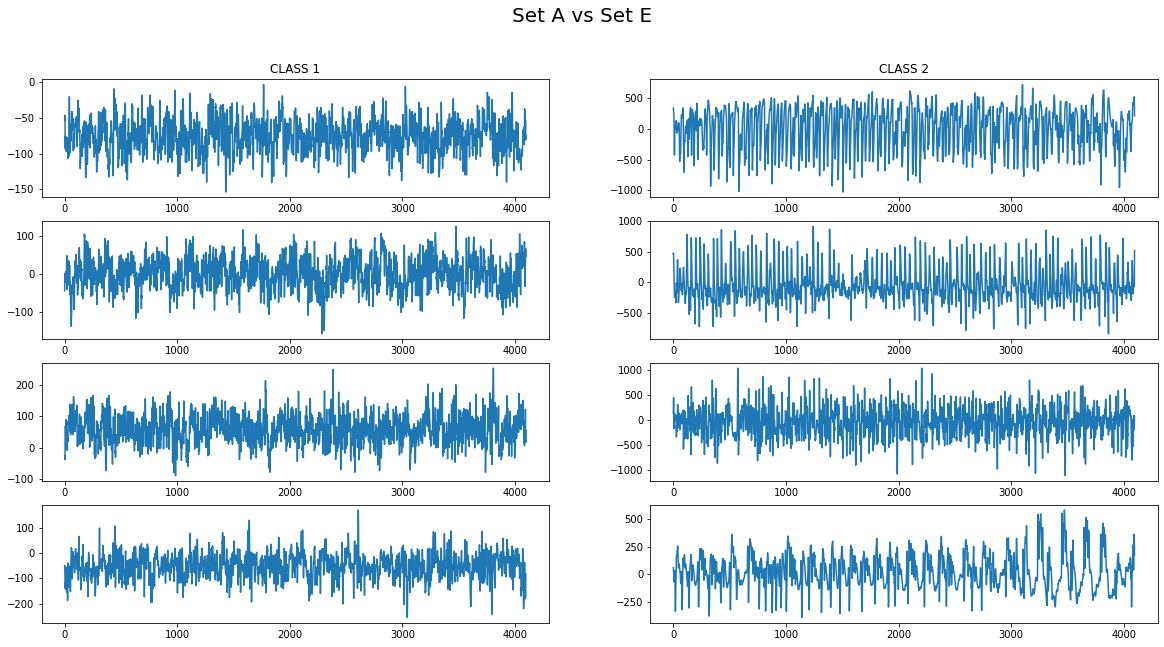

In [7]:
# data visualization

import random
mpl.rcParams['figure.figsize'] = (20,10)

fig = plt.figure()

samples_c1 = np.empty((0, 4097), int)
while len(samples_c1) < 4:
    curID = random.randint(0, len(data)) # random id between 0-200
    if data[curID][1] == LABEL_C1:
        samples_c1 = np.vstack((samples_c1, data[curID][0]))
        
samples_c2 = np.empty((0, 4097), int)
while len(samples_c2) < 4:
    curID = random.randint(0, len(data))
    if data[curID][1] == LABEL_C2:
        samples_c2 = np.vstack((samples_c2, data[curID][0]))
        
for i in range(0, 4):
    plt.subplot(421 + i * 2)
    plt.plot(samples_c1[i])
    plt.subplot(421 + i * 2 + 1)
    plt.plot(samples_c2[i])

ax = plt.subplot(421)
ax.set_title("CLASS 1")
ax = plt.subplot(422)
ax.set_title("CLASS 2")

fig.suptitle("Set A vs Set E", fontsize=20)
plt.show()

##**Data Preparation**

*   Split data into training and testing set, 80% training and 20% testing 
*   Convert the label to one-hot-encoded vectors: 0 >> [1,0] and 1 >> [0,1]



In [8]:
# data preparation

from sklearn.utils import shuffle
data = shuffle(data)

nb_train = round(len(data) * 0.8)
data_train = data[0:nb_train]
data_test = data[nb_train:]

X_train = np.array([d[0] for d in data_train])
Y_train = np.array([d[1] for d in data_train])

X_test = np.array([d[0] for d in data_test])
Y_test = np.array([d[1] for d in data_test])

    
X_train = X_train.reshape(X_train.shape[0], 4097, 1)
Y_train = Y_train.reshape(Y_train.shape[0], 1)

X_test = X_test.reshape(X_test.shape[0], 4097, 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)


print('Training data :',X_train.shape)
print('Training label:',Y_train.shape)
print('Testing data  :',X_test.shape)
print('Testing label :',Y_test.shape)

print('\nOriginal training label:\n',Y_train[0:3])


# Encode labels to hot vectors (ex : 2 -> 0=[1,0] and 1=[0,1])
from keras.utils import to_categorical

Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)


print('\nOne-hot encoded label:\n',Y_train[0:3])

Training data : (160, 4097, 1)
Training label: (160, 1)
Testing data  : (40, 4097, 1)
Testing label : (40, 1)

Original training label:
 [[0]
 [0]
 [1]]

One-hot encoded label:
 [[1. 0.]
 [1. 0.]
 [0. 1.]]


##**Model Training**
>>### Long Short Term Memory (LSTM)

>>![](https://drive.google.com/uc?id=1coyG3t6Mbe04WPn8xPdL-64zmdz1oidj)

[Source](https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/)





In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,BatchNormalization, LSTM
from keras.layers import Embedding
from keras.callbacks import EarlyStopping,ModelCheckpoint


batch_size =16
nb_epoch = 25
hidden_size = 128
use_dropout=True

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
chckpoint = ModelCheckpoint('./drive/My Drive/data/cuDNNlstm_model.h5', save_best_only=True, monitor='val_loss', mode='min')


model = Sequential()
model.add(LSTM(hidden_size, input_shape=(4097,1)))
model.add(Dropout(0.35))
model.add(Dense(2))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mae', 'acc'])
print(model.summary())

history = model.fit(X_train, Y_train, verbose=1, validation_data=(X_test, Y_test),shuffle=True, batch_size=batch_size, epochs=nb_epoch, callbacks=[earlyStopping,chckpoint])

model.save('./drive/My Drive/data/cuDNNlstm_model.h5')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 66,818
Trainable params: 66,818
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
10/10 [==============================] - 6s 595ms/step - loss: 0.6239 - mae: 0.4072 - acc: 0.6438 - val_loss: 0.3041 - val_mae: 0.2558 - val_acc: 1.0000
Epoch 2/25
10/10 [==============================] - 5s 501ms/step - loss: 0.395

##Plot Learning Curves
Should have something like this!
![alt text](https://drive.google.com/uc?id=1VysuZaAPPOYOvkP-BJ0Wpj-9oKNt8oyF)

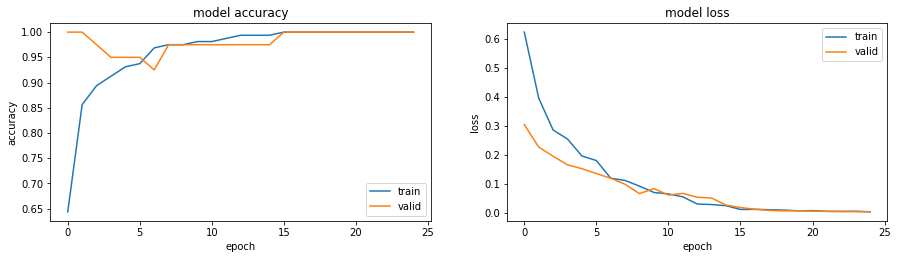

dict_keys(['loss', 'mae', 'acc', 'val_loss', 'val_mae', 'val_acc'])


In [13]:
import matplotlib.pyplot as plt

plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid'],loc='lower right') 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid'], loc='upper right') 

plt.show()

print(history.history.keys())

In [17]:
# Look at confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##**Standard Evaluation Metrics**



$$Precision = \frac{TP}{TP+FP} $$

$$Recall = \frac{TP}{TP+FN} $$

$$F1 = 2 * \frac{Precision*Recall}{Precision + Recall}$$



##**Model Evaluation**


****************** model loaded *******************
5/5 [==============================] - 1s 188ms/step - loss: 0.0027 - mean_absolute_error: 0.0027 - acc: 1.0000

[info] loss=0.003, accuracy: 100.000%


              precision    recall  f1-score   support

      normal       1.00      1.00      1.00        20
   epileptic       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



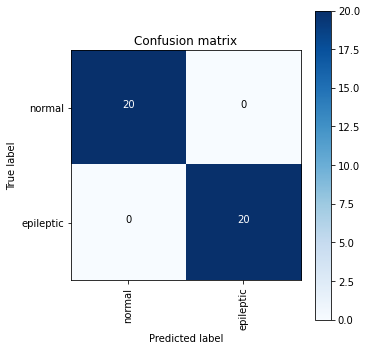

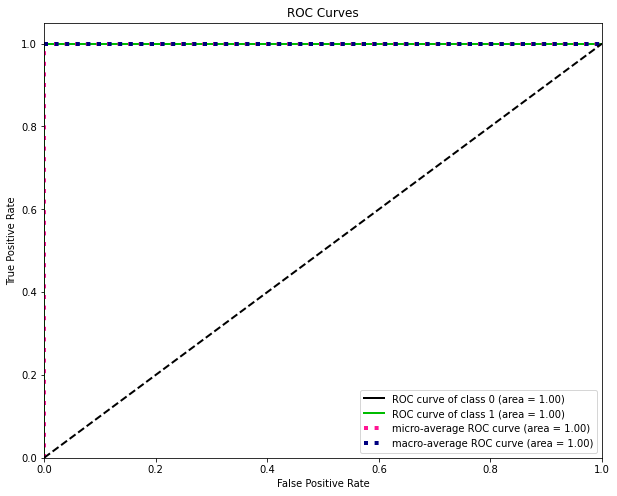

In [18]:
import itertools
import sklearn
from sklearn.metrics import confusion_matrix
import scikitplot
from keras.models import load_model, Model

# Load trained network
model = load_model('./drive/My Drive/data/cuDNNlstm_model.h5')    # ./drive/My Drive/data/cuDNNlstm_model.h5

print('\n****************** model loaded *******************')

batch_size = 8
# Evaluate the trained model
score = model.evaluate(X_test, Y_test, batch_size=batch_size)
print("\n[info] loss={:.3f}, accuracy: {:.3f}%\n".format(score[0],score[2] * 100))

# Make prediction
y_pred = model.predict(X_test) 
map_characters = {0: 'normal', 1: 'epileptic'}
print('\n', sklearn.metrics.classification_report(np.where(Y_test > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')

Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 

# plot confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))


# Plot roc curve:
scikitplot.metrics.plot_roc(np.argmax(Y_test, axis=1), y_pred, figsize=(10,8))
plt.show()

##**Visual Sanity Check**

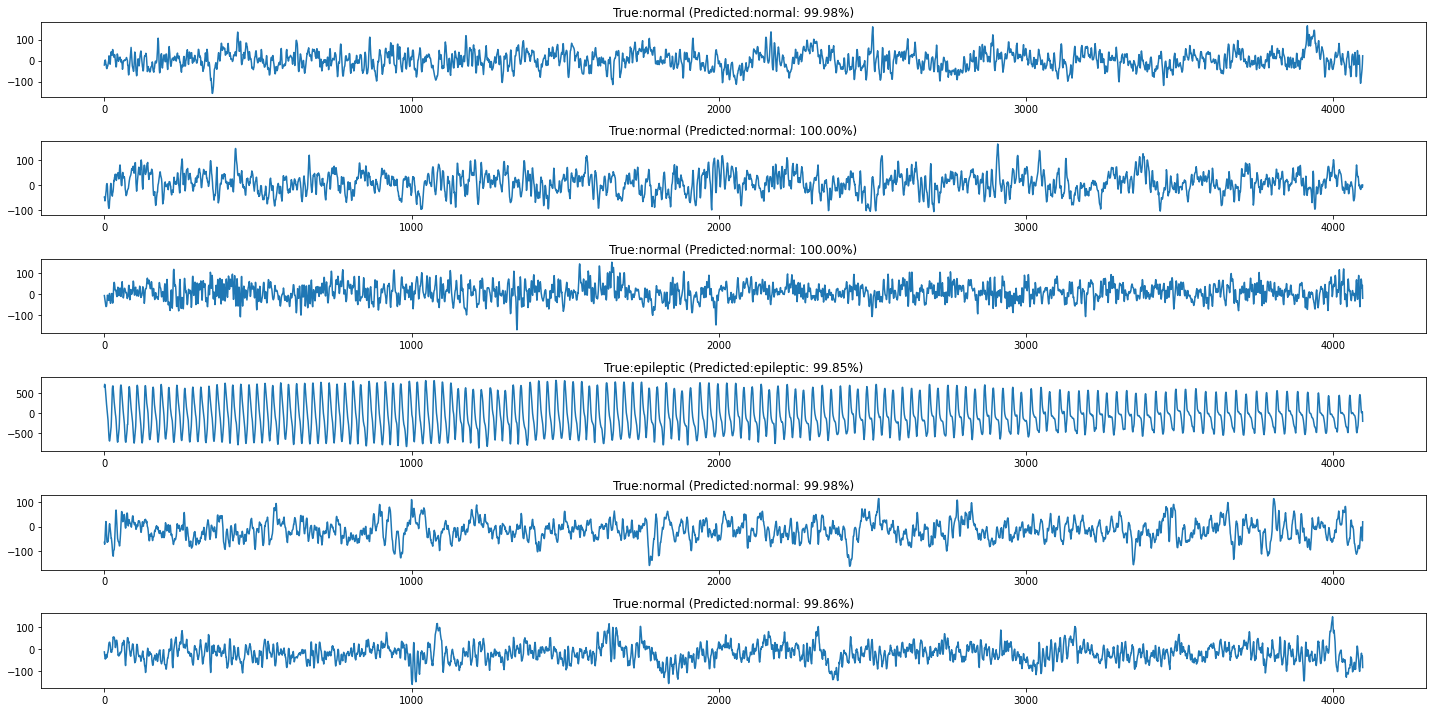

In [19]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cv2
from google.colab.patches import cv2_imshow
import random

idx = random.sample(range(0,40), 6) # regenerate random index

for i in range(6):
    (normal, epileptic) = model.predict(X_test)[idx[i]]
    label = "normal" if normal > epileptic else "epileptic"
    proba = epileptic if epileptic > normal else normal
    label = "{}: {:.2f}%".format(label, proba * 100)
    true_label = 'normal' if (Y_test[idx[i]] == 1)[0] else 'epileptic'
   
    plt.subplot(611+i)
    plt.plot(X_test[idx[i]])
    plt.title('True:{} (Predicted:{})'.format(true_label,label))
    plt.axis('on')
    plt.tight_layout()
         